<a href="https://colab.research.google.com/github/adasilvero/home-credit/blob/main/home_credit_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

'07-MINISTERIO DE EDUCACIÓN Y CULTURA-1.xlsx'
'2021-11-16 02-12-41.mkv'
'2021-12-11 18-14-04.mkv'
 2023-1096.pdf
 5833735.pdf
 818429-1.pdf
 acuerdoItaipu.pdf
'Anteproyecto Ada Silvero (1).pdf'
'Audio from Ada Silvero'
'Auditoria de la Informatica.rar'
 BoardingPass_MyNameOnMars2020.png
 CalendarioReservas.xlsx
 Certificados
 CI
'CIENCIA DE DATOS CURSO'
 CI.pdf
 Classroom
'Colab Notebooks'
'Control Ada Gabriela Silvero.xlsx'
'Crepiocas saladas H.docx'
 Curriculum_vitae_Ada_Silvero.docx
'CV-GABRIELA SILVERO.pdf'
'Data Mining_ A Knowledge Discovery Approach [Clos, Pedrycz, Swiniarski & Kurgan 2007-02-01].pdf'
'Desarrollo Interfaz WPF y XAML.mkv'
'Dieta Ada Gabriela Silvero 12.3.24 entre semana.docx'
'Dieta Ada Gabriela Silvero 12.3.24 FINES DE SEMANA.docx'
'Dieta Ada Gabriela Silvero 3.2.24.docx'
'Dieta Ada Gabriela Silvero 3.2.24 FINES DE SEMANA.docx'
'Estructura de Datos y Archivos'
 finanzas_V2.xlsx
 home_credit_balanceo.ipynb
 home_credit_default_risk
 home_credit_xgboost.ipynb
 JWA

In [ ]:
### Cargamos los datos
train_data = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/application_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/application_test.csv')
#contiene información sobre préstamos previos de los clientes en otras instituciones.
bureau = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/bureau.csv')
#datos históricos mensuales de los préstamos en bureau
bureau_balance = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/bureau_balance.csv')
#datos históricos de préstamos en puntos de venta y efectivo
pos_cash_balance = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/POS_CASH_balance.csv')
#datos históricos de saldos de tarjetas de crédito.
credit_card_balance = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/credit_card_balance.csv')
#información sobre solicitudes previas de crédito.
previous_application = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/previous_application.csv')
#datos de pagos de cuotas de préstamos anteriores.
installments_payments = pd.read_csv('/content/drive/MyDrive/home_credit_default_risk/installments_payments.csv')

# Definiendo las funcionas para mostrar los datos

In [ ]:
#Define una función que toma un DataFrame (df) y devuelve una tabla con información sobre los tipos de datos de sus columnas.
def df_dtypes(df):
    #Configura pandas para mostrar el contenido completo de las columnas sin truncarlas.
    pd.set_option('display.max_colwidth', None)
    #Agrupa las columnas del DataFrame por su tipo de datos (como int64, float64, etc.), las convierte en una lista y crea un nuevo DataFrame.
    df_dtypes = df.columns.to_series().groupby(df.dtypes.astype(str)).apply(list).reset_index()
    #Renombra las columnas del DataFrame resultante como dtype (tipo de datos) y columns (lista de columnas).
    df_dtypes.columns = ['dtype', 'columns']
    #Agrega una columna con el número de columnas por tipo de datos.
    df_dtypes['# columns'] = df_dtypes['columns'].apply(len)
    #Reordena las columnas para que sean dtype, # columns y columns
    df_dtypes = df_dtypes[['dtype', '# columns', 'columns']]
    # Aplica un estilo para alinear a la izquierda el contenido de la columna columns.
    df_dtypes = df_dtypes.style.set_properties(subset=['columns'], **{'text-align': 'left'})
    #Devuelve el DataFrame estilizado con la información de tipos de datos.
    return df_dtypes

Definición de funciones auxiliares

In [ ]:
#Define un umbral global de 60 valores únicos para clasificar características como categóricas o numéricas.
N_UNIQUE_THRESHOLD = 60

#Define una función que identifica columnas categóricas en el DataFrame.
def get_categorical_features(df, nunique_threshold=N_UNIQUE_THRESHOLD):
    #Devuelve una lista de columnas cuyos valores únicos (nunique) sean menores al umbral (categóricas).
    return [feature for feature in df.columns
            if df[feature].nunique() < nunique_threshold]

#Define una función que identifica columnas numéricas.
def get_numerical_features(df, nunique_threshold=N_UNIQUE_THRESHOLD):
    #Devuelve una lista de columnas numéricas (filtradas por np.number) con valores únicos mayores o iguales al umbral.
    return [feature for feature in df.select_dtypes(include=[np.number]).columns
            if df[feature].nunique() >= nunique_threshold]

Construcción de tabla informativa

Genera una tabla detallada con estadísticas por columna (tipo de datos, conteo, media, moda, valores nulos, etc.). Convierte booleanos a enteros y diferencia entre métricas numéricas y categóricas según el umbral.

In [ ]:
#Define una función que genera una tabla detallada con estadísticas de cada columna del DataFrame.
def build_my_info_table(df, nunique_threshold=N_UNIQUE_THRESHOLD):
    #Verifica si el DataFrame está vacío o es None, y en ese caso devuelve None.
    if df is None or df.empty:
        return None
    #Convierte columnas booleanas (True/False) a enteros (1/0).
    boolean_columns = df.select_dtypes(include='bool').columns
    df[boolean_columns] = df[boolean_columns].astype(int)
    #Obtiene la lista de características numéricas usando la función definida antes.
    numerical_features = get_numerical_features(df)
    #Inicializa una lista para almacenar las métricas de cada columna.
    metrics = []
    #Itera sobre cada columna del DataFrame con un índice (idx) y su nombre (col).
    for idx, col in enumerate(df.columns):
        #Extrae los datos de la columna actual.
        column_data = df[col]
        dtype   = column_data.dtypes
        count   = column_data.count()
        mean    = column_data.mean()   if col in numerical_features else ''
        std     = column_data.std()    if col in numerical_features else ''
        min_val = column_data.min()    if col in numerical_features else ''
        q25     = column_data.quantile(0.25) if col in numerical_features else ''
        median  = column_data.median() if col in numerical_features else ''
        q75     = column_data.quantile(0.75) if col in numerical_features else ''
        max_val = column_data.max()    if col in numerical_features else ''
        iqr     = max_val - min_val    if col in numerical_features else ''
        nunique = column_data.nunique()
        unique_values   = column_data.unique() if nunique < nunique_threshold else ''
        mode    = column_data.mode().iloc[0] if not column_data.mode().empty else ''
        mode_count      = column_data.value_counts().max() \
                                             if not column_data.value_counts().empty else ''
        mode_percentage = (round(mode_count * 100 / len(column_data), 1)
                                             if mode_count not in ['', None] else '')
        null_count      = column_data.isnull().sum()
        null_percentage = round(column_data.isnull().mean() * 100, 1)
        # Append the calculated metrics to the list
        metrics.append({
            "#": idx,
            "column": col,
            "dtype": dtype,
            "count": count,
            "mean": round(mean, 1)   if mean    not in ['', None] else '',
            "std": round(std, 1)     if std     not in ['', None] else '',
            "min": round(min_val, 1) if min_val not in ['', None] else '',
            "25%": round(q25, 1)     if q25     not in ['', None] else '',
            "50%": round(median, 1)  if median  not in ['', None] else '',
            "75%": round(q75, 1)     if q75     not in ['', None] else '',
            "max": round(max_val, 1) if max_val not in ['', None] else '',
            "IQR": round(iqr, 1)     if iqr     not in ['', None] else '',
            "nunique": nunique,
            "unique": unique_values,
            "mode": mode,
            "mode #": mode_count,
            "mode %": mode_percentage,
            "null #": null_count,
            "null %": null_percentage,
        })
    # Convert metrics list to DataFrame
    df_info = pd.DataFrame(metrics)
    # Ensure sorting by dtype is stable
    df_info = df_info.sort_values(by='dtype').reset_index(drop=True)
    return df_info

Preprocesamiento de datos

In [ ]:
def fillna_and_replace_inf(df):
    # Select numerical and categorical columns once
    numerical_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(exclude=[np.number]).columns
    # Fill missing values and replace infinities for numerical features
    for feature in numerical_features:
        df[feature].replace([np.inf, -np.inf], np.nan, inplace=True)
        median = df[feature].median()
        df[feature].fillna(median, inplace=True)
    # Fill missing values for categorical features
    for feature in categorical_features:
        if list(df[feature].mode()):
            mode = df[feature].mode()[0]
            df[feature].fillna(mode, inplace=True)
    return df

from sklearn.preprocessing import LabelEncoder

def encode_str_features(df):
    # Get list of categorical features
    categorical_features = get_categorical_features(df)
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    # Iterate over each categorical feature
    for feature in categorical_features:
        # Convert feature values to string (if not already) and encode with LabelEncoder
        df[feature] = label_encoder.fit_transform(df[feature].astype(str)).astype(np.int8)
    return df


Separación de datos


In [ ]:
#Separa el DataFrame en características (X) y variable objetivo (y).
def split_data_X_y(df, target_feature):
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    return X, y

#Extrae y elimina una columna de identificación (por defecto 'id').
def drop_id_feature(df, id_col='id'):
    df_id = df[id_col]
    df = df.drop(columns=[id_col])
    return df, df_id

Visualización

In [ ]:
#plot_bar_chart: Crea un gráfico de barras con seaborn, ajustando tamaño y límites dinámicamente.
def plot_bar_chart(df, x, y, xlabel, ylabel, title, xmin=None, xmax=None, palette='deep'):
    if df.shape[0] == 0:
        return
    size = (12, df.shape[0] / 4 + 1)
    plt.figure(figsize=size)
    sns.barplot(y=df[y], x=df[x], palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xmin is None or xmax is None:
        xrange = (df[x].max() - df[x].min()) * .1
        if xmin is None:
            xmin = max(0, df[x].min() - xrange) if df[x].min() >= 0 else df[x].min() - xrange
        if xmax is None:
            xmax = min(0, df[x].max() + xrange) if df[x].max() <= 0 else df[x].max() + xrange
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    plt.show()
#plot_line_chart: Crea un gráfico de líneas con matplotlib, incluyendo cuadrícula y marcadores.
def plot_line_chart(df, x, y, xlabel, ylabel, title, figsize=(12, 4)):
    if df.shape[0] == 0:
        return
    plt.figure(figsize=figsize)
    plt.plot(df[x], df[y], marker='o', label=ylabel)
    plt.xticks(df[x])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Extracción de características de fechas y tiempos

In [ ]:
def extract_date_features(df, date_columns):
    for feature in date_columns:
      #Convierte los valores de la columna a formato datetime usando pd.to_datetime.
      #Si hay valores inválidos (como texto no convertible a fecha), los reemplaza con NaN gracias a errors='coerce'.
        df[feature] = pd.to_datetime(df[feature], errors='coerce')
        df[feature + '_year']         = df[feature].dt.year.astype('int64')
        df[feature + '_month']        = df[feature].dt.month.astype('int64')
        df[feature + '_day']          = df[feature].dt.day.astype('int64')
        df[feature + '_weekday']      = df[feature].dt.weekday.astype('int64')
        df[feature + '_weekofyear']   = df[feature].dt.isocalendar().week.astype('int64')
        df[feature + '_quarter']      = df[feature].dt.quarter.astype('int64')
        df[feature + '_isweekend']    = df[feature + '_weekday'].isin([5, 6]).astype('int64')
        df[feature + '_isleapyear']   = df[feature].dt.is_leap_year.astype('int64')
        df[feature + '_ismonthend']   = df[feature].dt.is_month_end.astype('int64')
        df[feature + '_ismonthstart'] = df[feature].dt.is_month_start.astype('int64')
        #Calcula la estación del año:
        #Divide el mes en grupos de 3 (e.g., meses 1-3 = invierno, 4-6 = primavera, etc.).
        #Usa % 12 // 3 + 1 para mapear meses a números (1 a 4) y luego a nombres de estaciones.
        #Guarda el resultado como texto (object).
        df[feature + '_season']       = (df[feature].dt.month % 12 // 3 + 1).map({
                                          1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'
                                         }).astype('object')
    return df

def extract_time_features(df, time_columns):
    for feature in time_columns:
        df[feature] = pd.to_datetime(df[feature], errors='coerce')
        df[feature + '_hour']         = df[feature].dt.hour.astype('int64')
        df[feature + '_minute']       = df[feature].dt.minute.astype('int64')
        df[feature + '_second']       = df[feature].dt.second.astype('int64')
        df[feature + '_timeofday']    = pd.cut(df[feature].dt.hour,
                                               bins=[0, 6, 12, 18, 24],
                                               labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                               right=False).astype('object')
        df[feature + '_isnoon']       = (df[feature].dt.hour == 12).astype('int64')
        df[feature + '_ismidnight']   = (df[feature].dt.hour == 0).astype('int64')
        df[feature + '_minutegroup']  = pd.cut(df[feature].dt.minute,
                                               bins=[0, 15, 30, 45, 60],
                                               labels=['Early', 'Mid', 'Late', 'End'],
                                               right=False).astype('object')
    return df

Verificando resultados

In [ ]:
# Llama a la función con el DataFrame 'train'
#result = df_dtypes(train_data)
#display(result)  # En Jupyter, 'display' muestra tablas estilizadas

In [ ]:
#test_data.head()

In [ ]:
#bureau.head()

In [ ]:
#bureau_balance.head()

In [ ]:
#pos_cash_balance.head()

In [ ]:
#credit_card_balance.head()

In [ ]:
#previous_application.head()

In [ ]:
#installments_payments.head()

# Utilizando estas funciones

Contexto: bureau contiene información sobre préstamos previos de clientes en otras instituciones, mientras que bureau_balance tiene datos mensuales de esos préstamos (e.g., saldos o estado). Este bloque condensa los datos mensuales en estadísticas útiles y las añade a bureau.

Tomamos bureau_balance, calculamos cuántos meses hay (count), el mes más antiguo (min) y el más reciente (max) para cada préstamo (SK_ID_BUREAU).
Unimos estos datos a bureau para agregar esta info a cada préstamo.

In [ ]:
# Aggregate bureau_balance
bureau_balance_agg = bureau_balance.groupby("SK_ID_BUREAU").agg({
    "MONTHS_BALANCE": ["count", "min", "max"]
}).reset_index()
bureau_balance_agg.columns = ["_".join(col) for col in bureau_balance_agg.columns]

# Merge bureau_balance with bureau
bureau = bureau.merge(bureau_balance_agg, left_on="SK_ID_BUREAU", right_on="SK_ID_BUREAU_", how="left").drop("SK_ID_BUREAU_", axis=1)

Añade info resumida de los préstamos de cada cliente (cantidad, variedad y total de crédito) a los conjuntos principales de entrenamiento y prueba, para usarlos en análisis o modelos.

In [ ]:
# Aggregate bureau
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "SK_ID_BUREAU": "count",
    "CREDIT_ACTIVE": "nunique",
    "AMT_CREDIT_SUM": "sum"
}).reset_index()
bureau_agg.columns = ["SK_ID_CURR", "bureau_count", "credit_active_unique", "total_credit_sum"]

# Merge bureau with main datasets
train_data = train_data.merge(bureau_agg, on="SK_ID_CURR", how="left")
test_data  = test_data.merge(bureau_agg,  on="SK_ID_CURR", how="left")

Agrega un resumen del historial de solicitudes de cada cliente a los datos principales. Esto da más información sobre su comportamiento pasado (cuántas veces pidió crédito, cuánto pidió en promedio y cuánto le aprobaron en total), lo que puede ayudar a predecir si pagará o no en el futuro.

In [ ]:
# Load and process previous_application
previous_app_agg = previous_application.groupby("SK_ID_CURR").agg({
    "SK_ID_PREV": "count",
    "AMT_APPLICATION": "mean",
    "AMT_CREDIT": "sum"
}).reset_index()
previous_app_agg.columns = ["SK_ID_CURR", "prev_app_count", "avg_amt_app", "total_amt_credit"]

# Merge previous_application with main datasets
train_data = train_data.merge(previous_app_agg, on="SK_ID_CURR", how="left")
test_data  = test_data.merge(previous_app_agg, on="SK_ID_CURR", how="left")

Se agrega un resumen del historial de saldos en préstamos de punto de venta o efectivo a los datos principales. Esto muestra cuántas veces ha tenido actividad un cliente y cuánto tiempo promedio lleva con esos saldos, lo que puede ser útil para predecir su comportamiento financiero.

In [ ]:
# Load and process POS_CASH_balance
pos_cash_agg = pos_cash_balance.groupby("SK_ID_CURR").agg({
    "SK_ID_PREV": "count",
    "MONTHS_BALANCE": "mean"
}).reset_index()
pos_cash_agg.columns = ["SK_ID_CURR", "pos_cash_count", "avg_months_balance"]

# Merge POS_CASH_balance with main datasets
train_data = train_data.merge(pos_cash_agg, on="SK_ID_CURR", how="left")
test_data  = test_data.merge(pos_cash_agg, on="SK_ID_CURR", how="left")

Se agrega un resumen del uso de tarjetas de crédito de cada cliente (número de tarjetas y saldo promedio) a los datos principales. Esto ayuda a entender su historial con tarjetas para predecir algo, como si pagarán un préstamo.

In [ ]:
# Load and process credit_card_balance
credit_card_agg = credit_card_balance.groupby("SK_ID_CURR").agg({
    "SK_ID_PREV": "count",
    "AMT_BALANCE": "mean"
}).reset_index()
credit_card_agg.columns = ["SK_ID_CURR", "credit_card_count", "avg_credit_balance"]

# Merge credit_card_balance with main datasets
train_data = train_data.merge(credit_card_agg, on="SK_ID_CURR", how="left")
test_data  = test_data.merge(credit_card_agg, on="SK_ID_CURR", how="left")

Se agrega un resumen del historial de pagos de cuotas de cada cliente (número de pagos, total pagado y tiempo promedio de pago) a los datos principales. Esto ayuda a ver cómo han manejado sus deudas, útil para predecir si pagarán futuros préstamos.

In [ ]:
# Load and process installments_payments
insta_payments_agg = installments_payments.groupby("SK_ID_CURR").agg({
    "SK_ID_PREV": "count",
    "AMT_PAYMENT": "sum",
    "DAYS_ENTRY_PAYMENT": "mean"
}).reset_index()
insta_payments_agg.columns = ["SK_ID_CURR", "installments_count", "total_amt_payment", "avg_days_entry_payment"]

# Merge installments_payments with main datasets
train_data = train_data.merge(insta_payments_agg, on="SK_ID_CURR", how="left")
test_data  = test_data.merge(insta_payments_agg, on="SK_ID_CURR", how="left")

In [ ]:
#print(f'train.shape: {train_data.shape}')
#print(f'test.shape : {test_data.shape}')

In [ ]:
#print(set(train_data) - set(test_data))
#print(set(test_data) - set(train_data))

In [ ]:
#print(train_data)

In [ ]:
##print("Columnas en train_data:", train_data.columns)
##print("Columnas en test_data:", test_data.columns)
##print("Diferencia:", set(train_data.columns) - set(test_data.columns))

In [ ]:
##df_dtypes(train_data)

In [ ]:
categorical_features = get_categorical_features(train_data)
numerical_features   = get_numerical_features(train_data)
print(f'categorical_features: {len(categorical_features)}\n{categorical_features}')
print(f'numerical_features:   {len(numerical_features)}\n{numerical_features}')

categorical_features: 73
['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL

In [ ]:
info_table = build_my_info_table(train_data)

In [ ]:
#info_table[info_table['dtype'].astype(str).str.startswith(('object', 'datetime'))]

In [ ]:
info_table[info_table['dtype'].astype(str).str.startswith(('float'))]

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
41,95,DAYS_LAST_PHONE_CHANGE,float64,307510,-962.9,826.8,-4292.0,-1570.0,-757.0,-274.0,0.0,4292.0,3773,,0.0,37672,12.3,1,0.0
42,94,DEF_60_CNT_SOCIAL_CIRCLE,float64,306490,,,,,,,,,9,"[2.0, 0.0, 1.0, nan, 3.0, 5.0, 4.0, 7.0, 24.0,...",0.0,280721,91.3,1021,0.3
43,93,OBS_60_CNT_SOCIAL_CIRCLE,float64,306490,,,,,,,,,33,"[2.0, 1.0, 0.0, 4.0, 8.0, 10.0, nan, 7.0, 3.0,...",0.0,164666,53.5,1021,0.3
44,92,DEF_30_CNT_SOCIAL_CIRCLE,float64,306490,,,,,,,,,10,"[2.0, 0.0, 1.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, ...",0.0,271324,88.2,1021,0.3
45,91,OBS_30_CNT_SOCIAL_CIRCLE,float64,306490,,,,,,,,,33,"[2.0, 1.0, 0.0, 4.0, 8.0, 10.0, nan, 7.0, 3.0,...",0.0,163910,53.3,1021,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,62,COMMONAREA_MODE,float64,92646,0.0,0.1,0.0,0.0,0.0,0.0,1.0,1.0,3128,,0.0,9690,3.2,214865,69.9
115,61,YEARS_BUILD_MODE,float64,103023,0.8,0.1,0.0,0.7,0.8,0.8,1.0,1.0,154,,0.8301,2960,1.0,204488,66.5
116,58,APARTMENTS_MODE,float64,151450,0.1,0.1,0.0,0.1,0.1,0.1,1.0,1.0,760,,0.084,7522,2.4,156061,50.7
117,59,BASEMENTAREA_MODE,float64,127568,0.1,0.1,0.0,0.0,0.1,0.1,1.0,1.0,3841,,0.0,16598,5.4,179943,58.5


In [ ]:
info_table[info_table['dtype'].astype(str).str.startswith(('int'))]

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
0,0,SK_ID_CURR,int64,307511,278180.5,102790.2,100002,189145.5,278202.0,367142.5,456255,356253,307511,,100002,1,0.0,0,0.0
1,31,REGION_RATING_CLIENT_W_CITY,int64,307511,,,,,,,,,3,"[2, 1, 3]",2,229484,74.6,0,0.0
2,114,FLAG_DOCUMENT_20,int64,307511,,,,,,,,,2,"[0, 1]",0,307355,99.9,0,0.0
3,33,HOUR_APPR_PROCESS_START,int64,307511,,,,,,,,,24,"[10, 11, 9, 17, 16, 14, 8, 15, 7, 13, 6, 12, 1...",10,37722,12.3,0,0.0
4,34,REG_REGION_NOT_LIVE_REGION,int64,307511,,,,,,,,,2,"[0, 1]",0,302854,98.5,0,0.0
5,35,REG_REGION_NOT_WORK_REGION,int64,307511,,,,,,,,,2,"[0, 1]",0,291899,94.9,0,0.0
6,36,LIVE_REGION_NOT_WORK_REGION,int64,307511,,,,,,,,,2,"[0, 1]",0,295008,95.9,0,0.0
7,38,REG_CITY_NOT_WORK_CITY,int64,307511,,,,,,,,,2,"[0, 1]",0,236644,77.0,0,0.0
8,39,LIVE_CITY_NOT_WORK_CITY,int64,307511,,,,,,,,,2,"[0, 1]",0,252296,82.0,0,0.0
9,113,FLAG_DOCUMENT_19,int64,307511,,,,,,,,,2,"[0, 1]",0,307328,99.9,0,0.0


/tmp/ipython-input-10-568451403.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df[y], x=df[x], palette=palette)


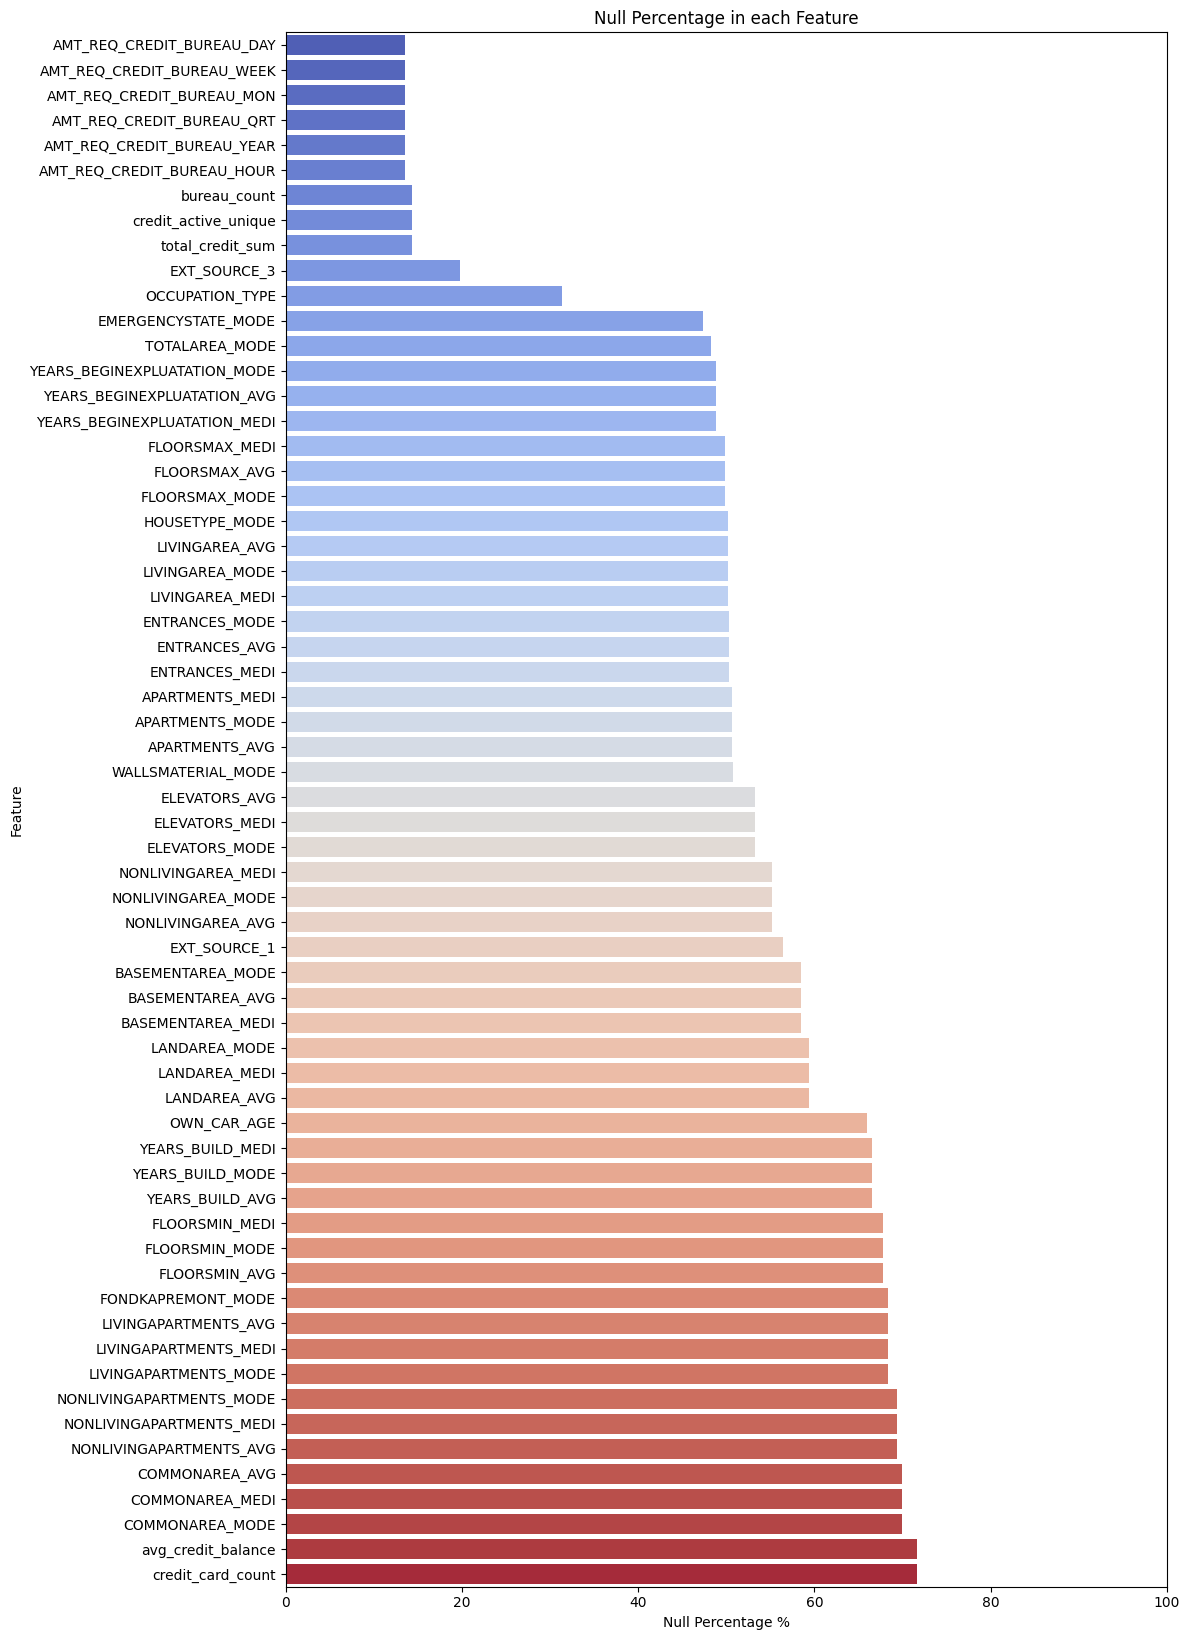

In [ ]:
nan_df = info_table[info_table['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column',
               xlabel='Null Percentage %', ylabel='Feature',
               title='Null Percentage in each Feature',
               xmin=0, xmax=100, palette='coolwarm')

Identifica automáticamente la columna objetivo (TARGET) que usarás para entrenar un modelo, ya que train_data tiene esta columna, pero test_data no.

In [ ]:
target_feature = list(set(train_data.columns)-set(test_data.columns))[0]
target_feature

'TARGET'

Quita columnas con más del 20% de valores nulos de ambos DataFrames (train_data y test_data), pero se asegura de no eliminar la columna objetivo (target_feature) de train_data.

In [ ]:
dropped_nan = set(nan_df[nan_df['null %'] > 20]['column'])
train_data = train_data.drop(columns=list(dropped_nan - set([target_feature])))
test_data  = test_data.drop(columns=list(dropped_nan - set([target_feature])))

In [ ]:
# Rellena valores faltantes en 'train' (mediana para numéricas, moda para categóricas) y reemplaza infinitos por NaN
train = fillna_and_replace_inf(train_data)

# Rellena valores faltantes en 'test' (mediana para numéricas, moda para categóricas) y reemplaza infinitos por NaN
test  = fillna_and_replace_inf(test_data)

# Bucle para procesar columnas de fechas/tiempos, pero está vacío ([]), así que no hace nada
for feature in []:
    # Extraería características de fechas (año, mes, etc.) de la columna 'feature' en 'train'
    train = extract_date_features(train, [feature])
    # Extraería características de fechas (año, mes, etc.) de la columna 'feature' en 'test'
    test = extract_date_features(test, [feature])
    # Extraería características de tiempo (hora, minuto, etc.) de la columna 'feature' en 'train'
    train = extract_time_features(train, [feature])
    # Extraería características de tiempo (hora, minuto, etc.) de la columna 'feature' en 'test'
    test = extract_time_features(test, [feature])
    # Convertiría la columna 'feature' a entero y la dividiría por 10^18 en 'train' (ajuste de valores grandes, como timestamps)
    train[feature] = train[feature].astype(int) / 10**18
    # Convertiría la columna 'feature' a entero y la dividiría por 10^18 en 'test' (ajuste de valores grandes, como timestamps)
    test[feature] = test[feature].astype(int) / 10**18

# Muestra una tabla con los tipos de datos de las columnas de 'train' (e.g., int64, float64) y cuántas hay de cada tipo
df_dtypes(train)

df_dtypes(test)

/tmp/ipython-input-8-417402470.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-8-417402470.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

,dtype,# columns,columns
0,float64,31,"['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'bureau_count', 'credit_active_unique', 'total_credit_sum', 'prev_app_count', 'avg_amt_app', 'total_amt_credit', 'pos_cash_count', 'avg_months_balance', 'installments_count', 'total_amt_payment', 'avg_days_entry_payment']"
1,int64,40,"['SK_ID_CURR', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']"
2,object,11,"['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']"


In [ ]:
# Define una constante para el tamaño del dataset ajustado (1000 muestras)
TUNE_DATASET_LEN = int(1e3)

# Calcula cuántas muestras tomar: el menor valor entre 1 millón y el tamaño de 'train'
n_samples = min(int(1e6), train.shape[0])

# Toma una muestra aleatoria de 'train' con 'n_samples' filas y la guarda en 'original_train'
original_train = train.sample(n_samples)

# Intercambia los DataFrames: 'train' pasa a ser 'original_train' y 'original_train' pasa a ser el 'train' original
original_train, train = train, original_train

/tmp/ipython-input-10-568451403.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df[y], x=df[x], palette=palette)


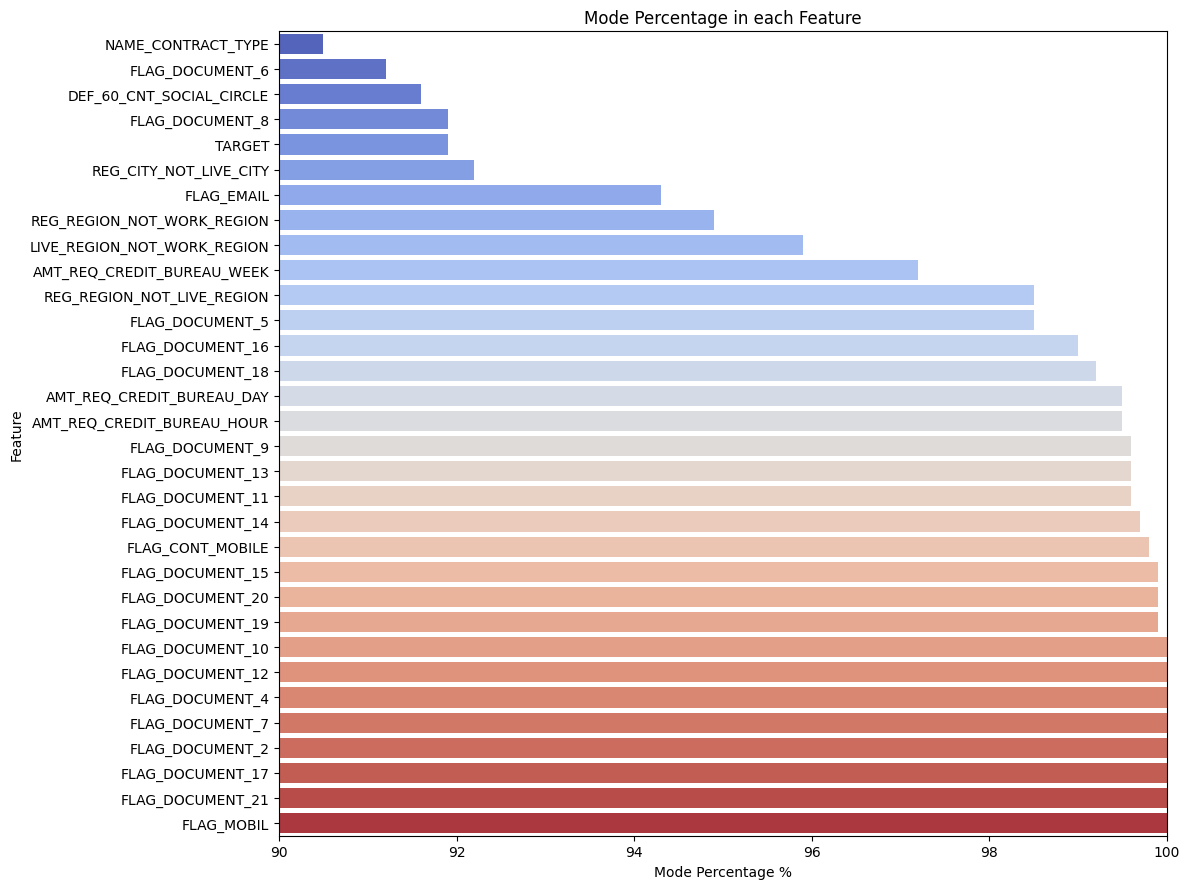

In [ ]:
# Genera una tabla con estadísticas detalladas (nulos, moda, etc.) para el DataFrame 'test'
info_table = build_my_info_table(test)

# Filtra columnas de 'info_table' con 10% o más de valores nulos, selecciona 'column' y 'null %', y ordena por 'null %'
nan_df = info_table[info_table['null %'] >= 10][['column', 'null %']].sort_values(by='null %')

# Grafica un diagrama de barras: porcentaje de nulos (X) vs. nombre de columnas (Y), con límites de 0 a 100 y paleta 'coolwarm'
plot_bar_chart(nan_df, x='null %', y='column',
               xlabel='Null Percentage %', ylabel='Feature',
               title='Null Percentage in each Feature',
               xmin=0, xmax=100, palette='coolwarm')

# Crea un conjunto con las columnas que tienen más del 20% de valores nulos
dropped_nan = set(nan_df[nan_df['null %'] > 20]['column'])

# Elimina de 'train' las columnas con más del 20% de nulos, pero protege 'target_feature' para no borrarla
train = train.drop(columns=list(dropped_nan - set([target_feature])))

# Elimina de 'test' las columnas con más del 20% de nulos, pero protege 'target_feature' (aunque 'test' no debería tenerla)
test  = test.drop(columns=list(dropped_nan - set([target_feature])))

# Codifica las columnas categóricas de 'train' como números enteros usando LabelEncoder
train = encode_str_features(train)

# Codifica las columnas categóricas de 'test' como números enteros usando LabelEncoder
test  = encode_str_features(test)

# Elimina la columna 'SK_ID_CURR' de 'train' y guarda el resultado (no guarda el ID eliminado)
train, _ = drop_id_feature(train, 'SK_ID_CURR')

# Elimina la columna 'SK_ID_CURR' de 'test' y guarda el ID eliminado en 'test_id'
test, test_id = drop_id_feature(test, 'SK_ID_CURR')

# Elimina todas las columnas no numéricas de 'train' (se queda solo con números)
train = train.drop(columns=train.select_dtypes(exclude=[np.number]).columns)

# Elimina todas las columnas no numéricas de 'test' (se queda solo con números)
test = test.drop(columns=test.select_dtypes(exclude=[np.number]).columns)

# Genera una nueva tabla de estadísticas para 'train' después de los cambios
info_table = build_my_info_table(train)

# Filtra columnas de 'info_table' donde el valor más frecuente ('mode') representa 90% o más, selecciona 'column' y 'mode %', y ordena
mode_df = info_table[info_table['mode %'] >= 90][['column', 'mode %']].sort_values(by='mode %')

# Grafica un diagrama de barras: porcentaje del valor más frecuente (X) vs. nombre de columnas (Y), con límites de 90 a 100 y paleta 'coolwarm'
plot_bar_chart(mode_df, x='mode %', y='column',
               xlabel='Mode Percentage %', ylabel='Feature',
               title='Mode Percentage in each Feature',
               xmin=90, xmax=100, palette='coolwarm')

In [ ]:
# Crea un conjunto con las columnas donde el valor más frecuente ('mode') representa más del 94%
dropped_mode = set(mode_df[mode_df['mode %'] > 94]['column'])

# Elimina de 'train' las columnas con 'mode' mayor a 94%, pero protege 'target_feature' para no borrarla
train = train.drop(columns=list(dropped_mode - set([target_feature])))

# Elimina de 'test' las columnas con 'mode' mayor a 94%, pero protege 'target_feature' (aunque 'test' no debería tenerla)
test = test.drop(columns=list(dropped_mode - set([target_feature])))

# Obtiene la lista de columnas categóricas en 'train' (menos de 60 valores únicos, según la función definida)
categorical_features = get_categorical_features(train)

# Obtiene la lista de columnas numéricas en 'train' (60 o más valores únicos, según la función definida)
numerical_features = get_numerical_features(train)

# Imprime el número y la lista de columnas categóricas
print(f'categorical_features: {len(categorical_features)}\n{categorical_features}')

# Imprime el número y la lista de columnas numéricas
print(f'numerical_features:   {len(numerical_features)}\n{numerical_features}')

# Imprime las dimensiones de 'train' (filas, columnas)
print(f'train.shape: {train.shape}')

# Imprime las dimensiones de 'test' (filas, columnas)
print(f'test.shape : {test.shape}')

categorical_features: 34
['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'credit_active_unique']
numerical_features:   22
['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2

In [ ]:
# Define una función para graficar un scatter plot con 'x1' y 'x2', coloreado por 'col', en el eje 'ax'
def my_scatterplot(df, col, ax):
    # Crea un scatter plot con 'x1' (eje X), 'x2' (eje Y), coloreado por 'col', usando paleta 'coolwarm'
    sns.scatterplot(data=df, x='x1', y='x2', hue=col, ax=ax, palette='coolwarm')
    # Establece el título del gráfico
    ax.set_title(f'Scatter Plot of {col}')
    # Coloca la leyenda fuera del gráfico, a la derecha
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Define una función para graficar múltiples características con funciones de visualización personalizadas
def plot_features(df, plot_funcs, width_ratios, height_ratios, n_col=1, primary_cols=0, title=None):
    def plot_feature(cols):
        # Calcula cuántas columnas se graficarán (excluyendo las primarias)
        cols_len = len(cols) - primary_cols
        # Ajusta los ratios de ancho según las columnas y funciones de graficación
        curr_width_ratios = width_ratios[:cols_len * len(plot_funcs)]
        # Calcula el número total de gráficos
        n_charts = len(plot_funcs) * cols_len

        # Crea una figura con tamaño y layout de grillas
        fig = plt.figure(figsize=(sum(curr_width_ratios), max(height_ratios)))
        # Define una grilla para los gráficos con los ratios especificados
        gs = fig.add_gridspec(1, n_charts, width_ratios=curr_width_ratios, height_ratios=height_ratios)
        # Inicializa una lista para los ejes de los gráficos
        axes = [0] * n_charts
        # Itera sobre las columnas y funciones para graficar cada característica
        for i in range(cols_len):
            for j in range(len(plot_funcs)):
                k = i * len(plot_funcs) + j
                # Añade un subplot a la grilla
                axes[k] = fig.add_subplot(gs[0, k])
                # Llama a la función de graficación con el DataFrame, columna y eje
                plot_funcs[j](df, cols[i + primary_cols], axes[k])
                # Si hay un título, lo añade a la figura
                if title:
                    fig.suptitle(title)

        # Ajusta el diseño para evitar superposiciones y muestra el gráfico
        plt.tight_layout()
        plt.show()

    # Itera sobre las columnas del DataFrame en grupos de 'n_col' para graficarlas
    for i in range(primary_cols, len(df.columns), n_col):
        plot_feature(list(df.columns[:primary_cols]) + list(df.columns[i:i+n_col]))

# Define una función para graficar la distribución de una característica de tipo datetime
def plot_datetime_feature(df, feature, palette='deep'):
    # Cuenta los valores de la característica y los ordena por índice
    feature_counts = df[feature].value_counts().sort_index()
    # Crea una figura de tamaño 12x4
    plt.figure(figsize=(12, 4))
    # Grafica un diagrama de barras con los valores contados, usando la paleta especificada
    sns.barplot(x=feature_counts.index, y=feature_counts.values, palette=palette)
    # Establece el título y etiquetas de los ejes
    plt.title(f'Count Plot for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    # Rota las etiquetas del eje X para mejor legibilidad
    plt.xticks(rotation=90)
    # Ajusta el diseño y muestra el gráfico
    plt.tight_layout()
    plt.show()

# Define una función para graficar un histograma con curva KDE de una columna
def my_histplot(df, col, ax):
    # Crea un histograma con curva de densidad (KDE) para la columna 'col' en el eje 'ax'
    sns.histplot(df[col], kde=True, ax=ax)
    # Establece el título del gráfico
    ax.set_title(f'Histogram Plot of {col}')

# Define una función para graficar una curva de densidad (KDE) de una columna
def my_kdeplot(df, col, ax):
    # Crea una curva de densidad para la columna 'col' en el eje 'ax', con relleno
    sns.kdeplot(df[col], ax=ax, fill=True)
    # Establece el título del gráfico
    ax.set_title(f'KDE Plot of {col}')

# Define una función para graficar la distribución de una columna (obsoleta, usa histplot en su lugar)
def my_distplot(df, col, ax):
    # Crea un gráfico de distribución para la columna 'col' en el eje 'ax'
    sns.distplot(df[col], ax=ax)
    # Establece el título del gráfico
    ax.set_title(f'Distribution Plot of {col}')

# Define una función para graficar un boxplot de una columna
def my_boxplot(df, col, ax):
    # Crea un boxplot vertical para la columna 'col' en el eje 'ax'
    sns.boxplot(y=df[col], ax=ax)

# Define una función para graficar un violinplot de una columna
def my_violinplot(df, col, ax):
    # Crea un violinplot vertical para la columna 'col' en el eje 'ax'
    sns.violinplot(y=df[col], ax=ax)

# Define una función para graficar un gráfico de pastel de una columna categórica
def my_pie_chart(df, col, ax):
    # Calcula los conteos de los valores de la columna 'col'
    labels = df[col].value_counts()
    # Crea un gráfico de pastel con porcentajes y etiquetas
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    # Establece el título del gráfico
    ax.set_title(f'Pie Chart of {col}')

# Define una función para graficar un diagrama de barras de una columna categórica
def my_barplot(df, col, ax):
    # Calcula los conteos de los valores de la columna 'col' y los ordena de mayor a menor
    value_counts = df[col].value_counts().sort_values(ascending=False)
    # Crea un diagrama de barras horizontal con los conteos, ordenado
    sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, orient='h', order=value_counts.index)
    # Establece el título y etiquetas de los ejes
    ax.set_title(f'Bar Plot of {col}')
    ax.set_xlabel('Count')
    ax.set_ylabel(col)

# Define una función para graficar características numéricas usando funciones de visualización
def plot_numerical_features(df, plot_funcs=[my_boxplot, my_violinplot, my_distplot],
                            width_ratios=[2, 2, 8], height_ratios=[4],
                            n_col=1, primary_cols=0, title=None):
    # Llama a 'plot_features' para graficar las características numéricas con las funciones especificadas
    plot_features(df, plot_funcs, width_ratios * n_col, height_ratios, n_col, primary_cols, title)

# Define una función para graficar características categóricas usando funciones de visualización
def plot_categorical_features(df, plot_funcs=[my_pie_chart, my_barplot],
                              width_ratios=[4, 8], height_ratios=[4],
                              n_col=1, primary_cols=0, title=None):
    # Llama a 'plot_features' para graficar las características categóricas con las funciones especificadas
    plot_features(df, plot_funcs, width_ratios * n_col, height_ratios, n_col, primary_cols, title)

# Importa herramientas para crear mapas de colores personalizados
from matplotlib.colors import LinearSegmentedColormap

# Define una función para graficar un mapa de calor de correlaciones
def my_heatmap(df, size, cmap, cbar_kws, font_size):
    # Crea una figura con el tamaño especificado
    plt.figure(figsize=size)
    # Grafica un mapa de calor de las correlaciones del DataFrame, con anotaciones y paleta personalizada
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap=cmap, center=0,
                cbar_kws=cbar_kws, annot_kws={"size": font_size})
    # Establece el título del gráfico
    plt.title('Correlation Heatmap')
    # Muestra el gráfico
    plt.show()

# Define una función para preparar y graficar un mapa de calor de correlaciones
def plot_heatmap(df, size_factor=1/2):
    # Selecciona solo las columnas numéricas del DataFrame
    df = df.select_dtypes(include=[np.number])
    # Calcula el tamaño de la figura basado en el número de columnas
    height = int(len(df.columns) * size_factor)
    # Si no hay columnas numéricas, termina la función
    if not height:
        return
    # Define el tamaño de la fuente para las anotaciones, ajustado al tamaño del gráfico
    font_size = max(min(12, 119 // height), 8)
    # Crea una paleta de colores personalizada (de azul a rojo)
    cmap = LinearSegmentedColormap.from_list(
        'custom_diverging',
        ['blue', 'lightblue', 'white', 'lightcoral', 'red'],
        N=5
    )
    # Define los ticks para la barra de color del mapa de calor
    cbar_kws = {'ticks': [-1, -.5, 0, .5, 1]}
    # Llama a 'my_heatmap' para graficar el mapa de calor con los parámetros definidos
    my_heatmap(df, size=(height+1, height+1), cmap=cmap, cbar_kws=cbar_kws, font_size=font_size)

# Importa PCA para reducción de dimensionalidad
from sklearn.decomposition import PCA

# Define una función para graficar datos etiquetados en 2D usando PCA
def plot_labeled_data(X, labels, figsize=(12, 4), n_components=2, n_col=1):
    # Si 'n_components' es mayor que el número de columnas en 'X', añade columnas dummy
    if n_components > X.shape[1]:
        for i in range(X.shape[1], n_components):
            X[f'x{i+1}'] = 1  # Añade columnas con valor 1 para cumplir con 'n_components'

    # Aplica PCA para reducir 'X' a 'n_components' dimensiones (por defecto 2D)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Crea un DataFrame con los datos transformados por PCA y columnas 'x1', 'x2', etc.
    df = pd.DataFrame(X_pca, columns=[f'x{i+1}' for i in range(n_components)])
    # Añade las etiquetas al DataFrame para visualización
    for name in labels:
        df[f'Applying\n{name}'] = labels[name]

    # Grafica los datos transformados usando 'plot_features' con un scatter plot
    plot_features(df,
                  plot_funcs=[my_scatterplot],
                  width_ratios=[figsize[0]] * n_col,
                  height_ratios=[figsize[1]],
                  n_col=n_col,
                  primary_cols=n_components)

# Define una función para reemplazar categorías raras en una columna categórica
def replace_rare_categories(df, feature, class_name, threshold_percent):
    # Calcula el umbral de conteo basado en el porcentaje especificado
    threshold_count = len(df) * (threshold_percent / 100)
    # Obtiene los conteos de los valores de la columna 'feature'
    value_counts = df[feature].value_counts()
    # Identifica las categorías raras (con conteo menor al umbral)
    rare_categories = value_counts[value_counts < threshold_count].index
    # Reemplaza las categorías raras por 'class_name' (e.g., 'Other')
    df[feature] = df[feature].apply(lambda x: class_name if x in rare_categories else x)
    # Devuelve el DataFrame modificado
    return df

In [ ]:
# Select only numerical columns
numeric_cols = train.select_dtypes(include=['number']).columns # guarda las columnas que tiene valor numerico
numeric_data = train[numeric_cols] # devuelve esas columnas

# Correlación con TARGET
correlations = numeric_data.corr()['TARGET'].sort_values(ascending=False)

print("📊 Top 15 correlaciones positivas con TARGET:")
print(correlations.head(15))
print("\n📊 Top 15 correlaciones negativas con TARGET:")
print(correlations.tail(15))

📊 Top 15 correlaciones positivas con TARGET:
TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_EDUCATION_TYPE            0.054699
CODE_GENDER                    0.054692
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
NAME_INCOME_TYPE               0.046829
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
avg_days_entry_payment         0.042304
DAYS_REGISTRATION              0.041975
Name: TARGET, dtype: float64

📊 Top 15 correlaciones negativas con TARGET:
installments_count           -0.019139
avg_amt_app                  -0.019964
FLAG_OWN_CAR                 -0.021851
total_amt_payment            -0.022203
FLAG_PHONE                   -0.023806
FLAG_DOCUMENT_6              -0.028602
AMT_CREDIT                   -0.030369
ORGANIZ

In [ ]:
#plot_numerical_features(train[numerical_features])


In [ ]:
#print("Columnas de train:", train.columns)
#print("Columnas de test:", test.columns)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
# Dividir el dataset en características (X) y objetivo (y) - Asegúrate de que 'train' esté definido
X = train.drop(columns=["TARGET"])
y = train["TARGET"]

In [ ]:
from sklearn.model_selection import train_test_split
# División 70/30 (usando tu ejemplo)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
model = XGBClassifier(scale_pos_weight=5, eval_metric="logloss", use_label_encoder=False)
model.fit(X_train_70, y_train_70)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:14:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions_proba_70 = model.predict_proba(X_test_30)[:, 1]  # Probabilidades de la clase positiva
predictions_70 = model.predict(X_test_30)  # Predicciones de cla

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
  # Evaluar y mostrar resultados en el mismo formato que tu matriz
  print("=== Resultados para división 70/30")
  print(f"Precisión: {accuracy_score(y_test_30, predictions_70):.4f}")
  print("\nInforme de clasificación:")
  print(classification_report(y_test_30, predictions_70))
  print("\nMatriz de confusión:")
  print(confusion_matrix(y_test_30, predictions_70))  # Formato [[TN, FP], [FN, TP]]

  # Opcional: Verificar las dimensiones para evitar errores
  #print(f"Longitud y_test_30: {len(y_test_30)}, Longitud y_pred_adjusted_70: {len(y_pred_adjusted_70)}")

=== Resultados para división 70/30
Precisión: 0.8675

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     84806
           1       0.26      0.34      0.29      7448

    accuracy                           0.87     92254
   macro avg       0.60      0.63      0.61     92254
weighted avg       0.88      0.87      0.88     92254


Matriz de confusión:
[[77525  7281]
 [ 4943  2505]]


Aqui lo que hacemos es tomar el test y:
*   Genera predicciones: Toma un conjunto de datos de entrada (características) y devuelve las etiquetas predichas para esas instancias basándose en el modelo entrenado.
*   Clasificación: En el caso de LogisticRegression, .predict() devuelve la clase predicha (por ejemplo, 0 o 1) para cada fila de los datos de entrada, según la probabilidad calculada por el modelo. Internamente, usa un umbral de 0.5: si la probabilidad estimada es mayor a 0.5, predice la clase positiva (por ejemplo, 1); de lo contrario, predice la clase negativa (por ejemplo, 0).
*   Entrada requerida: Espera un array o DataFrame con las mismas características (columnas) que se usaron durante el entrenamiento con .fit(), excluyendo la variable objetivo (como TARGET).

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Dividir el dataset en características (X) y objetivo (y) - Asegúrate de que 'train' esté definido
X = train.drop(columns=["TARGET"])
y = train["TARGET"]

In [ ]:
# --- Opción 1: División 80/20 ---
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Opción 2: División 70/30 ---
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
# Balancear con SMOTE para la división 80/20
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_80_res, y_train_80_res = smote.fit_resample(X_train_80, y_train_80)

# Balancear con SMOTE para la división 70/30
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_70_res, y_train_70_res = smote.fit_resample(X_train_70, y_train_70)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Escalar datos para ambas divisiones
scaler = StandardScaler()
X_train_80_res = scaler.fit_transform(X_train_80_res)
X_test_20 = scaler.transform(X_test_20)
X_train_70_res = scaler.fit_transform(X_train_70_res)
X_test_30 = scaler.transform(X_test_30)

## ¿Qué hace C=1.0?
C es un parámetro que controla la regularización del modelo de regresión logística. La regularización es como una regla que evita que el modelo se "aprenda de memoria" los datos de entrenamiento (sobreajuste) y prefiera soluciones más simples.

*   Valor pequeño de C (por ejemplo, 0.0001): Hace que la regularización sea fuerte. El modelo es muy cauteloso, usa menos las características y puede subajustar (no capturar bien los patrones).
*   Valor grande de C (por ejemplo, 1000): Hace que la regularización sea débil. El modelo confía más en los datos y puede sobreajustar (memorizarlos).
*   C=1.0: Es un valor intermedio. Significa una regularización moderada, permitiendo que el modelo use las características de manera razonable sin exagerar ni ignorarlas demasiado. Es un punto de partida común y equilibrado.


En términos simples: C=1.0 le dice al modelo que confíe en los datos, pero no tanto como para copiarlos exactamente, buscando un balance entre aprender bien y generalizar a nuevos datos.

In [ ]:
# Entrenar el modelo para la división 80/20
log_reg_80 = LogisticRegression(C=1, max_iter=1000)
log_reg_80.fit(X_train_80_res, y_train_80_res)

# Entrenar el modelo para la división 70/30
log_reg_70 = LogisticRegression(C=1, max_iter=1000)
log_reg_70.fit(X_train_70_res, y_train_70_res)

LogisticRegression(C=1, max_iter=1000)

In [ ]:
# Predecir con umbral ajustado para la división 80/20
predictions_proba_80 = log_reg_80.predict_proba(X_test_20)[:, 1]
y_pred_adjusted_80 = (predictions_proba_80 > 0.4).astype(int)

# Predecir con umbral ajustado para la división 70/30
predictions_proba_70 = log_reg_70.predict_proba(X_test_30)[:, 1]
y_pred_adjusted_70 = (predictions_proba_70 > 0.4).astype(int)

Con este codigo:


# Evaluar y mostrar resultados para la división 80/20
print("=== Resultados para división 80/20 con ajustes ===")
print(f"Precisión: {accuracy_score(y_test_20, y_pred_adjusted_80):.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_20, y_pred_adjusted_80))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_20, y_pred_adjusted_80))
print(f"Longitud y_test_20: {len(y_test_20)}, Longitud y_pred_adjusted_80: {len(y_pred_adjusted_80)}")

# Evaluar y mostrar resultados para la división 70/30
print("\n=== Resultados para división 70/30 con ajustes ===")
print(f"Precisión: {accuracy_score(y_test_30, y_pred_adjusted_70):.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_30, y_pred_adjusted_70))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_30, y_pred_adjusted_70))
print(f"Longitud y_test_30: {len(y_test_30)}, Longitud y_pred_adjusted_70: {len(y_pred_adjusted_70)}")

Este resultado:


=== Resultados para división 80/20 con ajustes ===
Precisión: 0.8063

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     56538
           1       0.15      0.31      0.20      4965

    accuracy                           0.81     61503
   macro avg       0.54      0.58      0.55     61503
weighted avg       0.87      0.81      0.83     61503


Matriz de confusión:
[[48071  8467]
 [ 3447  1518]]
Longitud y_test_20: 61503, Longitud y_pred_adjusted_80: 61503

=== Resultados para división 70/30 con ajustes ===
Precisión: 0.8078

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     84806
           1       0.15      0.30      0.20      7448

    accuracy                           0.81     92254
   macro avg       0.54      0.58      0.55     92254
weighted avg       0.87      0.81      0.84     92254


Matriz de confusión:
[[72266 12540]
 [ 5190  2258]]
Longitud y_test_30: 92254, Longitud y_pred_adjusted_70: 92254

In [ ]:
# Evaluar y mostrar resultados para la división 80/20
print("=== Resultados para división 80/20 con ajustes ===")
print(f"Precisión: {accuracy_score(y_test_20, y_pred_adjusted_80):.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_20, y_pred_adjusted_80))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_20, y_pred_adjusted_80))
print(f"Longitud y_test_20: {len(y_test_20)}, Longitud y_pred_adjusted_80: {len(y_pred_adjusted_80)}")

# Evaluar y mostrar resultados para la división 70/30
print("\n=== Resultados para división 70/30 con ajustes ===")
print(f"Precisión: {accuracy_score(y_test_30, y_pred_adjusted_70):.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_30, y_pred_adjusted_70))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_30, y_pred_adjusted_70))
print(f"Longitud y_test_30: {len(y_test_30)}, Longitud y_pred_adjusted_70: {len(y_pred_adjusted_70)}")

=== Resultados para división 80/20 con ajustes ===
Precisión: 0.8093

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     56538
           1       0.16      0.31      0.21      4965

    accuracy                           0.81     61503
   macro avg       0.54      0.58      0.55     61503
weighted avg       0.87      0.81      0.84     61503


Matriz de confusión:
[[48243  8295]
 [ 3434  1531]]
Longitud y_test_20: 61503, Longitud y_pred_adjusted_80: 61503

=== Resultados para división 70/30 con ajustes ===
Precisión: 0.8090

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     84806
           1       0.16      0.31      0.21      7448

    accuracy                           0.81     92254
   macro avg       0.55      0.58      0.55     92254
weighted avg       0.87      0.81      0.84     92254


Matriz de confusión:
[[72305 12501]
 

## Random Forest

Inicializamos un clasificador Random Forest con 100 árboles, configurado para ser reproducible, mostrar progreso y aprovechar todos los núcleos del procesador.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

¿Qué es un "classifier"?
Un classifier (clasificador) es un modelo de machine learning diseñado para resolver problemas de clasificación, donde el objetivo es predecir la categoría o clase de una observación basada en sus características. En tu caso, RandomForestClassifier es un clasificador que predice la clase de la variable objetivo (por ejemplo, TARGET, que podría ser 0 o 1).

Características de un clasificador:
Entrada: Recibe un conjunto de características (features) de los datos.
Salida: Devuelve una etiqueta de clase (por ejemplo, 0 o 1 en un problema binario).
Ejemplo: Si tienes datos de clientes y quieres predecir si comprarán un producto (TARGET: 0 = no, 1 = sí), un clasificador como Random Forest analiza las características (edad, ingresos, etc.) y predice la clase (0 o 1).
Random Forest como clasificador:
Random Forest es un tipo de clasificador que:

Construye muchos árboles de decisión, cada uno entrenado con una muestra aleatoria de los datos.
Cada árbol hace una predicción (vota por una clase).
La clase con más votos entre todos los árboles es la predicción final.
Esto hace que Random Forest sea robusto, menos propenso al sobreajuste que un solo árbol de decisión, y efectivo para problemas de clasificación complejos.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dividir el dataset en características (X) y objetivo (y)
X = train.drop(columns=["TARGET"])
y = train["TARGET"]

# --- Opción 1: División 80/20 ---
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Opción 2: División 70/30 ---
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Crear el modelo Random Forest para ambas divisiones

# Construir 100 árboles (n_estimators=100).
# Hacer los resultados reproducibles (random_state=50).
# Mostrar mensajes de progreso (verbose=1).
# Usar todos los núcleos del procesador para mayor velocidad (n_jobs=-1).
random_forest_80 = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest_70 = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

# Entrenar los modelos
# 80/20
random_forest_80.fit(X_train_80, y_train_80)
# 70/30
random_forest_70.fit(X_train_70, y_train_70)

# Hacer predicciones de probabilidad y clase
# Para 80/20
predictions_proba_80 = random_forest_80.predict_proba(X_test_20)[:, 1]  # Probabilidades de la clase positiva
predictions_80 = random_forest_80.predict(X_test_20)  # Predicciones de clase

# Para 70/30
predictions_proba_70 = random_forest_70.predict_proba(X_test_30)[:, 1]  # Probabilidades de la clase positiva
predictions_70 = random_forest_70.predict(X_test_30)  # Predicciones de clase

# Evaluar el rendimiento
print("=== Resultados para división 80/20 ===")
print(f"Precisión: {accuracy_score(y_test_20, predictions_80):.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_20, predictions_80))

#[[Verdaderos Negativos (TN), Falsos Positivos (FP)],
#[Falsos Negativos (FN), Verdaderos Positivos (TP)]]
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_20, predictions_80))

print("\n=== Resultados para división 70/30 ===")
print(f"Precisión: {accuracy_score(y_test_30, predictions_70):.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_30, predictions_70))

#[[Verdaderos Negativos (TN), Falsos Positivos (FP)],
#[Falsos Negativos (FN), Verdaderos Positivos (TP)]]
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_30, predictions_70))



# Si quieres las importancias de las características (descomenta las líneas correspondientes)
#feature_importance_values_80 = random_forest_80.feature_importances_
#feature_importances_80 = pd.DataFrame({'feature': X_train_80.columns, 'importance': feature_importance_values_80})
#print("\nImportancias de características para 80/20:")
#print(feature_importances_80.sort_values(by='importance', ascending=False))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel

=== Resultados para división 80/20 ===
Precisión: 0.9193

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.50      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503


Matriz de confusión:
[[56530     8]
 [ 4957     8]]

=== Resultados para división 70/30 ===
Precisión: 0.9194

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84806
           1       0.69      0.00      0.00      7448

    accuracy                           0.92     92254
   macro avg       0.81      0.50      0.48     92254
weighted avg       0.90      0.92      0.88     92254


Matriz de confusión:
[[84798     8]
 [ 7430    18]]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.3s finished


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dividir el dataset en características (X) y objetivo (y) - Asegúrate de que 'train' esté definido
X = train.drop(columns=["TARGET"])
y = train["TARGET"]

# Split data
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate scale_pos_weight
scale_pos_weight_80 = len(y_train_80[y_train_80 == 0]) / len(y_train_80[y_train_80 == 1])
scale_pos_weight_70 = len(y_train_70[y_train_70 == 0]) / len(y_train_70[y_train_70 == 1])

# XGBoost for 80/20
xgb_model_80 = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_80,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model_80.fit(X_train_80, y_train_80)
predictions_proba_80 = xgb_model_80.predict_proba(X_test_20)[:, 1]
y_pred_adjusted_80 = (predictions_proba_80 > 0.4).astype(int)

# XGBoost for 70/30
xgb_model_70 = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_70,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model_70.fit(X_train_70, y_train_70)
predictions_proba_70 = xgb_model_70.predict_proba(X_test_30)[:, 1]
y_pred_adjusted_70 = (predictions_proba_70 > 0.4).astype(int)

# Evaluate
print("=== XGBoost Results for 80/20 Split ===")
print(f"Accuracy: {accuracy_score(y_test_20, y_pred_adjusted_80):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_20, y_pred_adjusted_80))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_20, y_pred_adjusted_80))

print("\n=== XGBoost Results for 70/30 Split ===")
print(f"Accuracy: {accuracy_score(y_test_30, y_pred_adjusted_70):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_30, y_pred_adjusted_70))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_30, y_pred_adjusted_70))

=== XGBoost Results for 80/20 Split ===
Accuracy: 0.5942

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.72     56538
           1       0.14      0.79      0.24      4965

    accuracy                           0.59     61503
   macro avg       0.56      0.68      0.48     61503
weighted avg       0.90      0.59      0.68     61503


Confusion Matrix:
[[32622 23916]
 [ 1041  3924]]

=== XGBoost Results for 70/30 Split ===
Accuracy: 0.5968

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.73     84806
           1       0.14      0.78      0.24      7448

    accuracy                           0.60     92254
   macro avg       0.55      0.68      0.48     92254
weighted avg       0.90      0.60      0.69     92254


Confusion Matrix:
[[49217 35589]
 [ 1610  5838]]
